In [22]:
import os
import sys
import glob
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set(style="ticks")
from sklearn.preprocessing import MinMaxScaler

In [23]:
srs_50k = pd.read_csv("50k_srs_songs.csv")
pop_70k = pd.read_csv("top70ksongs.csv")

In [24]:
col_of_interest = ["danceability","energy","key","loudness","mode","speechiness",
                   "acousticness","instrumentalness","liveness", "valence", "tempo", "duration_ms"]

## Description of our EDA ##

For our EDA, we first got data for the songs within each playlist using the Spotify API. The information that we derived from this is described below. We anticipate using the Spotify API further later in our project to get the top playlists to further evaluate the performance of our model.

We do three types of EDA below:
* EDA of information about the playlists (duration of playlist, number of songs from a single artist, number of songs in a playlist)

* EDA of audio features for songs, clustered by playlist

* EDA of audio features for general songs

## Description of Data for Songs

From the spotify API, we were able to get the following audio features for each track. Below, we have listed them with a description of what they represent:

* **DANCEABILITY:** Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. 
* **ENERGY:** Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale.
* **KEY:** The estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1.
* **LOUDNESS:** The overall loudness of a track in decibels (dB) ranging from -60 to 0. Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. 
* **MODE:** Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.
* **SPEECHINESS:** Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks
* **ACOUSTICNESS:** A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic. 
* **INSTRUMENTALNESS:** Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. 
* **LIVENESS:** Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. Values range from 0 to 1 with a value above 0.8 providing strong likelihood that the track is live. 
* **VALENCE:** A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).
* **TEMPO:** The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.

## EDA Thought Process and Results for data in Playlists


In [18]:
full_df = pd.read_csv("playlist_data.csv")

In [ ]:
songs_in_playlist = full_df.groupby(["fid", "pid"]).pos.max()

In [ ]:
songs_in_playlist.describe()

This tells us the distribution of the number of songs in a playlist. The mean is about 65 with a standard deviation of about 54. The minimum number of songs in the playlists that we have is 4 and the maximum is 375.

In [ ]:
plt.hist(songs_in_playlist)
plt.show()

In [ ]:
full_df.groupby(["fid", "pid", "artist_uri"]).pos.count().describe()

This tells us the distribution of how many songs there are in a playlist by the same artist. The mean is around 2 songs by the same artist. The minimum is 1 song and the maximum is 245 songs by the same artist, which makes sense because someone could have a playlist solely based off of one artist's songs.

In [ ]:
full_df.groupby(["fid", "pid"]).duration_ms.sum() / 60000

This tells us the distribution of the total duration of playlists. The max value is an outlier, which is a playlist that lasts over 10,000 minutes. At first, we thought this may have been an error in the data, but upon further inspection, the playlist just has songs that are mixes, which last a very long time (average around 26 minutes).

## EDA Thought Process and Results on Songs Clustered by Playlists


In [25]:
full_50_df = pd.read_csv('complete_playlists_50.csv')

In [26]:
# Standardize values so that we can see variance on the same scale later 
for i in col_of_interest:
    full_50_df[i] = MinMaxScaler().fit_transform(full_50_df[i].values.reshape(-1,1))
    
# Find variance of each feature in the 50 playlists
playlist_variance = full_50_df.groupby(["fid",'pid']).var()
playlist_variance.head()

,,pos,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
fid,pid,,,,,,,,,,,,,,
16,705,368.500000,0.001583,0.009252,0.019309,0.104560,0.001888,0.248019,0.010111,0.012009,0.032633,0.020121,0.029451,0.012232,0.015152
29,736,3.500000,0.002229,0.024922,0.016280,0.142149,0.000886,0.166667,0.000677,0.016139,0.007790,0.001504,0.063813,0.014886,0.000000
52,746,101.175676,0.002431,0.019373,0.025859,0.140595,0.007580,0.247748,0.019274,0.027657,0.001101,0.026698,0.050108,0.019467,0.027027
112,480,3451.000000,0.000768,0.010404,0.018977,0.100911,0.003482,0.207189,0.003816,0.015333,0.003518,0.028689,0.046586,0.016486,0.009803
113,190,208.490196,0.001324,0.020430,0.040405,0.098130,0.005042,0.148235,0.001224,0.080724,0.012160,0.011439,0.060898,0.019944,0.139608


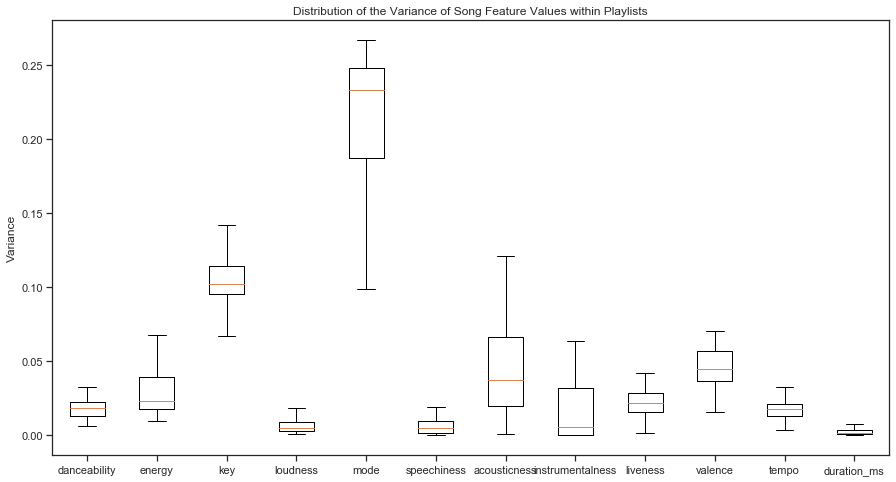

In [27]:
var_list = []

for x in range(len(col_of_interest)):
    var_list.append(playlist_variance[col_of_interest[x]])
    
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(15,8))
ax.boxplot(var_list, showfliers=False)
ax.set_title("Distribution of the Variance of Song Feature Values within Playlists")
ax.set_ylabel("Variance")
ax.set_xticklabels(col_of_interest)

plt.show()

We also took a look at the variance in features expressed in the songs chosen for inclusion within individual playlists.  We took a subset of 50 full playlists from the Spotify API, and from this dataset, found the audio features for each song in each playlist. We then standardized the values (by each feature) so that the variance can be seen at the same scale. We then made the above boxplot, showing the distribution of the variances of each feature across the 50 playlists. 

As we can see from the above boxplots, there clearly *are* some features that tend to cluster together within playlists; for instance, danceability has on average a relatively low variance across all songs in a playlist.  This means, simply, that most of the songs in any one playlist will tend to have the same values for danceability.  This seems intuitively to make sense: playlists are often made with or without dancing in mind, so a song that is less danceable would not fit into a playlist with songs that are very danceable.  In other words, playlists may tend to select for danceability.  On the other end, acousticness and mode had relatively higher variances, meaning that these features may not necessarily be selected for in particular when people create playlists.  These trends from our EDA will be important to consider when moving on with the project.

## EDA Thought Process and Results on Songs in General

For part of our EDA, we decided it would be a good idea to look at the songs within the playlists. We derived two subsets of songs from the playlists with the audio features described above:
* One random subset of 50,000 songs
* The most popular 70,000 songs (as measured by frequency of apperance in playlists)

We wanted to compare the audio features within these two subsets to compare whether or not a simple random sample of songs would have significantly different features from a subset of the most popular songs.

We did this in two ways: using summary statistics and comparing distributions.

## Comparing Summary Statistics

In [ ]:
srs_50k.describe()

In [ ]:
pop_70k.describe()

From the summary statistics, we see that the means and standard deviations for most of the features are similar with a few exceptions. Energy has a greater mean in the popular song subset. Loudness, acousticness, instrumentalness, and duration_ms have smaller means and smaller variances in the subset of popular songs. 

However, we cannot simply rely on summary statistics to tell us everything about the data. Therefore, we will graph the distributions of the data and compare them as well.

## Comparing Distributions

In [ ]:
## Made two boxes so that our images would fit on one page
fig, ax = plt.subplots(3,2, figsize = (15,15))
fig.subplots_adjust(hspace=.2, wspace=.4)
axes = ax.ravel()

for i in range(6):
    sns.distplot(srs_50k[col_of_interest[i]], ax = axes[i], kde = True, label = "Simple Random Sample")
    sns.distplot(pop_70k[col_of_interest[i]], ax = axes[i], kde = True, label = "Popular Songs")
    axes[i].legend()
    axes[i].set_xlabel(col_of_interest[i])
    axes[i].set_ylabel("Frequency")

In [ ]:
## Continuation of plots above
fig, ax = plt.subplots(3,2, figsize = (15,15))
fig.subplots_adjust(hspace=.2, wspace=.4)
axes = ax.ravel()

for i in range(6,12):
    sns.distplot(srs_50k[col_of_interest[i]], ax = axes[i-6], kde = True, label = "Simple Random Sample")
    sns.distplot(pop_70k[col_of_interest[i]], ax = axes[i-6], kde = True, label = "Popular Songs")
    axes[i-6].legend()
    axes[i-6].set_xlabel(col_of_interest[i])
    axes[i-6].set_ylabel("Frequency")

We wanted to check the distribution of audio features in both of these subsets and compare them to see whether or not the distributions of the random subset would be different from the distribution of the most popular songs of the playlists we have. 

From the plots above, we see that most of the distributions are not very different. The ones that we identified that are potentially different are: loudness, acousticness, energy, duration_ms, and instrumentalness. 

* In the "loudness" plot, we see greater concentration of values around 0 for the popular songs, potentially suggesting that more popular songs are louder.

* In the "acousticness" plot, we see a stronger drop off of values from 0 to 1, suggesting that the distribution of the more popular songs have less acoustic songs.

* In the "instrumentalness" plot, we see a similar steeper drop off of values from 0 to 1, suggesting that the distribution of the more popular songs have less instrumental songs as well.

* In the "energy" plot, we see that there is a greater concentration of larger values in the popular songs distribution. This suggests that more popular songs have greater energy. 

* In the "duration_ms" plot, though it hard to see, there is larger spike in smaller values for the popular songs distribution. This suggests that more popular songs are shorter in duration.

More generally, we see that the audio features have different distributions of values. We have a mix of left-skewed (energy, loudness), right-skewed (liveness, instrumentalness, acousticness, speechiness, duration_ms) and normal (danceability, tempo, valence) data. 